In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
death_data = pd.read_csv("../clean_data/ma_town_opioid_overdose_death_by_place_of_death_2014_to_2018.csv")
ma_town_map = gpd.read_file("../raw_data/townssurvey_shp/TOWNSSURVEY_POLYM.shp")

In [3]:
death_data.head()

,city_death,2014,2015,2016,2017,2018
0,abington,0,6,1,3,5
1,acton,1,2,3,0,1
2,acushnet,0,4,2,4,0
3,adams,2,3,1,0,4
4,agawam,1,2,0,4,8


In [4]:
ma_town_map['TOWN'] = ma_town_map['TOWN'].str.lower()

In [5]:
ma_map_json = [0]

In [6]:
len(set(ma_town_map['TOWN']))

351

In [7]:
len(set(death_data['city_death']))

351

In [8]:
set(ma_town_map['TOWN']) - set(death_data['city_death'])

{'north attleborough'}

In [9]:
set(death_data['city_death']) - set(ma_town_map['TOWN'])

{'north attleboro'}

In [10]:
death_data['city_death'] = death_data['city_death'].str.replace('north attleboro', 'north attleborough')

In [11]:
town_death_map = ma_town_map.merge(death_data, how='inner', left_on='TOWN', right_on='city_death')

In [12]:
town_death_map.drop('city_death', axis=1, inplace=True)

In [13]:
#town_death_map.to_file("town_death_map.geojson", driver='GeoJSON')

In [14]:
town_death_map_json = gpd.read_file("town_death_map.geojson")

In [15]:
type(town_death_map)

geopandas.geodataframe.GeoDataFrame

In [16]:
town_death_map_json.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,2014,2015,2016,2017,2018,geometry
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,27982,1378,26738.594369,2.726958e+07,0,1,0,0,0,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,28886,-38,28960.012825,3.294777e+07,0,1,2,1,0,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,1234,54,73405.706629,1.767489e+08,0,0,0,0,0,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,24747,1039,23126.471303,2.587450e+07,2,2,4,4,1,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,92271,4246,87188.934275,4.484078e+07,39,43,36,37,35,"(POLYGON ((242254.612499997 895020.5045999996,..."


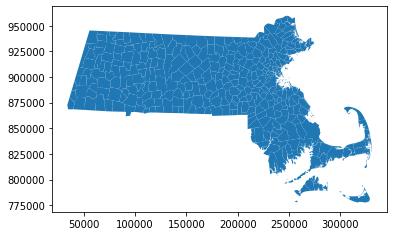

In [17]:
town_death_map.plot()

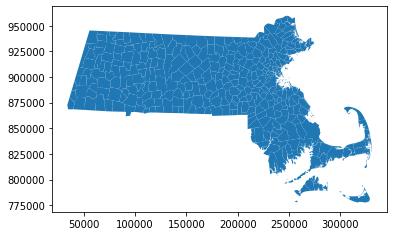

In [18]:
town_death_map_json.plot()

In [19]:
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [27]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x|y') of edges/vertices of a Polygon/others"""

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

In [28]:
town_death_map['x'] = town_death_map.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
town_death_map['y'] = town_death_map.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

In [29]:
town_death_map.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,SHAPE_Leng,SHAPE_Area,geometry,2014,2015,2016,2017,2018,x,y
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,...",0,1,0,0,0,"[[219129.01250000298, 219160.8224999979, 21922...","[[897474.7045999989, 897473.864599999, 897475...."
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,...",0,1,2,1,0,"[222991.1424999982, 223015.26250000298, 223043...","[895149.4145999998, 895140.5346000008, 895140...."
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,...",0,0,0,0,0,"[150592.65250000358, 141963.6625000015, 140800...","[914968.5846000016, 907702.2646000013, 905247...."
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344...",2,2,4,4,1,"[232551.0625, 233440.6424999982, 233678.652500...","[923891.9946000017, 923267.9846000001, 923154...."
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,...",39,43,36,37,35,"[[242254.61249999702, 242257.90250000358, 2422...","[[895020.5045999996, 895011.9246000014, 895007..."


In [31]:
town_death_map_json

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,2014,2015,2016,2017,2018,geometry
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,27982,1378,26738.594369,2.726958e+07,0,1,0,0,0,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,28886,-38,28960.012825,3.294777e+07,0,1,2,1,0,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,1234,54,73405.706629,1.767489e+08,0,0,0,0,0,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,24747,1039,23126.471303,2.587450e+07,2,2,4,4,1,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,92271,4246,87188.934275,4.484078e+07,39,43,36,37,35,"(POLYGON ((242254.612499997 895020.5045999996,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,somerville,274,75836,76210,77478,374,1268,C,4,25017,...,75754,-1724,19884.219455,1.069865e+07,14,15,19,12,8,"POLYGON ((230662.7124999985 907352.6845999993,..."
347,pembroke,231,13882,14544,16927,662,2383,T,4,25023,...,17837,910,42341.724263,6.100547e+07,3,2,5,1,0,"POLYGON ((259609.4624999985 874160.1746000014,..."
348,duxbury,82,13174,13895,14248,721,353,T,1,25023,...,15059,811,99884.166652,6.232911e+07,0,0,2,0,0,(POLYGON ((266547.2325000018 868791.5045999996...
349,boxford,38,5751,6266,7921,515,1655,T,3,25009,...,7965,44,44884.884100,6.321618e+07,0,0,0,0,0,"POLYGON ((233567.7524999976 943010.8845999986,..."


In [32]:
def getPolyCoords2(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""

    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1] )

In [33]:
town_death_map_json['x'] = town_death_map_json.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
town_death_map_json['y'] = town_death_map_json.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

In [34]:
p = figure(title="MA")
p.multi_line('x', 'y', source=town_death_map_json, color="black", line_width=2)
show(p)

TypeError: Object of type 'MultiPolygon' is not JSON serializable